[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/crunchdao/quickstarters/blob/master/competitions/broad-1/quickstarters/basic-eda/basic-EDA.ipynb)

# Broad Institute: Autoimmune Disease Machine Learning Challenge

![Cover](https://raw.githubusercontent.com/crunchdao/quickstarters/refs/heads/master/competitions/broad-1/assets/cover.png)

## Crunch 1 – Quickstarter

## The Problem

Autoimmune diseases arise when the immune system mistakenly targets healthy cells. Affecting 50M people in the U.S., with rising global cases, Inflammatory Bowel Disease (IBD) is one of the most prevalent forms. IBD involves a breakdown in the gut barrier, triggering the immune system to attack proteins erroneously recognized as foreign, leading to persistent inflammation. This cycle of flares and remission increases the risk of colorectal cancer (up to two-fold). Although modern treatments have improved survival, IBD remains challenging to diagnose and treat due to its complex symptoms and multifactorial nature.
Pathologists rely on gut tissue images to diagnose and treat IBD, guiding decisions on the most suitable drug treatments and predicting cancer risk. These tissue images, combined with recent advances in genomics, offer a valuable dataset for machine learning models to revolutionize IBD diagnosis and treatment.

## The Solution

In Crunch 1, you will train an algorithm to predict spatial transcriptomics data (gene expression in each cell). In other words predict the gene expression (Y) in cells from specific tissue patches based on the H&E images (X) and surrounding spatial transcriptomics data.

#### X (Input):

- **HE_registered**: The registered H&E image, aligned to the Xenium spatial transcriptomics coordinate system. This is the recommended file to use as it is already aligned with the spatial transcriptomics data.

- **HE_original**: The original H&E image in its native pixel coordinates, before alignment. If you prefer to handle alignment yourself, you can use this, but it may require additional processing.

#### Y (Output):

- **anucleus**: This file contains the aggregated gene expression data for each nucleus. It is log1p-normalized and stores the gene expression profiles for 460 genes per nucleus. This is the primary target (Y) for your model.

- **transcripts**: This file contains the spatial locations and individual gene expression data for each transcript in the tissue, linked to specific nuclei. It provides the raw gene expression information before aggregation.

## Notes

* `HE_registered` is only in data_large
* [train data] Retrive coordinate systems: matching bw spatial transcriptomics & HE
* train data split: based on clustering results on spatial transcriptomics

* From initail EDA, many training cells have nucleus really nearby. Existing models predict tile-level (64x64 or 128x128 pixels in size) transcriptomics, often much lower resolution than single cell level. Do we need to build cell-level feature learning in addition to sub-tissue level??? And how? (nearby cells? cell type classification from cell/nucleus shape?) Or just to average a sub-tissue res tile expression for every single cell in the same tile? Can have a look at cell type classifications from marker genes corr. them to cellular shapes (<- cellular segmentation masks).


# Setup Step
install and import pkgs

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
assert os.getcwd() == '/content'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install --upgrade crunch-cli
!pip install numpy pandas torch scipy openslide-python pydantic pytorch-lightning dask distributed matplotlib seaborn scikit-learn opencv-python scanpy squidpy spatialdata zarr ome-zarr

  Using cached spatialdata-0.2.6-py3-none-any.whl.metadata (9.6 kB)
  Using cached multiscale_spatial_image-2.0.2-py3-none-any.whl.metadata (25 kB)
  Using cached xarray-2024.11.0-py3-none-any.whl.metadata (11 kB)
Using cached spatialdata-0.2.6-py3-none-any.whl (168 kB)
Using cached multiscale_spatial_image-2.0.2-py3-none-any.whl (29 kB)
Using cached xarray-2024.11.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: xarray
    Found existing installation: xarray 2024.7.0
    Uninstalling xarray-2024.7.0:
      Successfully uninstalled xarray-2024.7.0
  Attempting uninstall: multiscale-spatial-image
    Found existing installation: multiscale_spatial_image 1.0.1
    Uninstalling multiscale_spatial_image-1.0.1:
      Successfully uninstalled multiscale_spatial_image-1.0.1
  Attempting uninstall: spatialdata
    Found existing installation: spatialdata 0.2.5.post0
    Uninstalling spatialdata-0.2.5.post0:
      Successfully uninstalled spatialdata-0.2.5.post0
ERROR: pip's dependency resol

In [156]:
# Registering to this Crunch

# Step 1:
# Create an account here: https://hub.crunchdao.com/auth/register

# Step 2:
# Get your set token here: https://hub.crunchdao.com/competitions/broad-1/submit/via/notebook
# !crunch setup --notebook broad hello --token aaaabbbbccccddddeeeeffff
!crunch setup --notebook --size large broad-1 test-platform --token tCZlxWIe5cP2NOpZ64iReG3pi3HI6hrayepxy0x0CVkHhhE5bOOkWO6DcXk1Ohxe --model-directory "/content/drive/My Drive/Colab Notebooks/202412-Crunch-broad-immune/broad1/crunch_database/data_large"


main.py: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/15828/main.py (64856 bytes)
notebook.ipynb: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/15828/notebook.ipynb (1449547 bytes)
requirements.txt: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/15828/requirements.original.txt (296 bytes)
resources/pytorch_model.bin: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/models/16958/pytorch_model.bin (102545229 bytes)
data/UC1_I.zarr.large.zip: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/81/UC1_I.zarr.large.zip (5417685446 bytes)
data/UC1_I.zarr.large.zip: uncompress into data/UC1_I.zarr.large.zip.9roh08gp
data/UC7_I.zarr.large.zip: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/81/UC7_I.zarr.large.zip (5083691963 byt

# Data Preparation

## Imports

In [87]:
"""
This is a basic example of what you need to do to enter the competition.
The code will not have access to the internet (or any socket related operation).
"""
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import spatialdata as sd
# import spatialdata_plot
import scanpy as sc
import squidpy as sq

## The datasets

In [6]:
datadir = "/content/drive/My Drive/Colab Notebooks/202412-Crunch-broad-immune/broad1/crunch_database/data"

sdata = sd.read_zarr(f"{datadir}/UC1_NI.zarr")
sdata

/usr/local/lib/python3.10/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /content/drive/My Drive/Colab Notebooks/202412-Crunch-broad-immune/broad1/crunch_database/data/UC1_NI.zarr
├── Images
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 21000, 22000)
│     └── 'HE_original': DataArray[cyx] (3, 21000, 22000)
└── Tables
      ├── 'anucleus': AnnData (80037, 460)
      └── 'cell_id-group': AnnData (93686, 0)
with coordinate systems:
    ▸ 'global', with elements:
        HE_nuc_original (Images), HE_original (Images)

## Input (X) - H&E Images

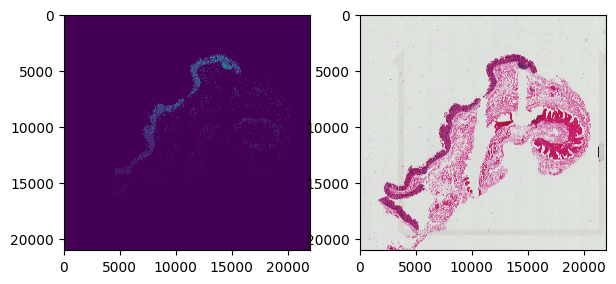

In [34]:
##  H&E pathology image
fig, axes = plt.subplots(1, 2, figsize=(7, 5))
axes = axes.flatten()  # Flatten the axes to easily index them
# sdata.pl.render_images("HE_nuc_original").pl.show(ax=axes[0], title="H&E registered image", coordinate_systems="global")
# sdata.pl.render_images("HE_original").pl.show(ax=axes[1], title="H&E original image", coordinate_systems="global")

axes[0].imshow(sdata["HE_nuc_original"][0, :, :].to_numpy())
rgb_image_t = np.transpose(sdata["HE_original"].to_numpy(), (1, 2, 0))
axes[1].imshow(rgb_image_t)

## Target (Y) -  aggregated gene expression data for each cell

In [14]:
## Get the list of gene concerned in crunch 1
gene_name_list = sdata['anucleus'].var['gene_symbols'].values
print(len(gene_name_list))

460


In [15]:
x_count = pd.DataFrame(sdata['anucleus'].layers['counts'], columns=gene_name_list) # raw count data
display(x_count)

,A2M,ACP5,ACTA2,ADAMTSL3,AFAP1L2,AHR,ALDH1B1,ANO1,ANXA1,AQP1,...,VCAN,VIL1,VIM,VPREB3,VWA5A,WFDC2,XBP1,XCL2,XCR1,ZEB2
0,1,0,9,0,0,0,0,0,2,0,...,0,0,4,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,12,0,...,0,0,3,0,0,0,0,0,0,0
2,2,0,1,0,2,4,0,0,0,0,...,0,0,9,0,0,0,0,0,0,2
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,6,0,0,0,0,0,2,0,...,0,0,3,0,1,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80032,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
80033,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
80034,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
80035,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [16]:
x_norm = pd.DataFrame((sdata['anucleus'].X), columns=gene_name_list) # normalized data
display(x_norm)

,A2M,ACP5,ACTA2,ADAMTSL3,AFAP1L2,AHR,ALDH1B1,ANO1,ANXA1,AQP1,...,VCAN,VIL1,VIM,VPREB3,VWA5A,WFDC2,XBP1,XCL2,XCR1,ZEB2
0,0.960462,0.0,2.741880,0.0,0.000000,0.000000,0.0,0.0,1.441210,0.0,...,0.0,0.000000,2.008430,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,2.726919,0.0,...,0.0,0.000000,1.519826,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
2,1.309063,0.0,0.854990,0.0,1.309063,1.857142,0.0,0.0,0.000000,0.0,...,0.0,0.000000,2.577346,0.0,0.000000,0.0,0.000000,0.0,0.0,1.309063
3,1.712979,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,0.862832,0.0,2.221286,0.0,0.000000,0.000000,0.0,0.0,1.319012,0.0,...,0.0,0.000000,1.631119,0.0,0.862832,0.0,0.000000,0.0,0.0,1.631119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80032,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.862832,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
80033,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,1.466337,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
80034,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.759105,0.759105,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
80035,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.817938,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.817938,0.0,0.0,0.000000


In [17]:
## Selecting training cells
cell_id_example = sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'train']['cell_id'].to_numpy()
cell_id_example = list(set(cell_id_example).intersection(set(sdata['anucleus'].obs['cell_id'].unique())))

## Get y from the anucleus data
ground_truth_example = sdata['anucleus'].layers['counts'][sdata['anucleus'].obs['cell_id'].isin(cell_id_example),:]

In [18]:
y = pd.DataFrame(ground_truth_example, columns= gene_name_list, index = cell_id_example)
y

,A2M,ACP5,ACTA2,ADAMTSL3,AFAP1L2,AHR,ALDH1B1,ANO1,ANXA1,AQP1,...,VCAN,VIL1,VIM,VPREB3,VWA5A,WFDC2,XBP1,XCL2,XCR1,ZEB2
1,1,0,9,0,0,0,0,0,2,0,...,0,0,4,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,12,0,...,0,0,3,0,0,0,0,0,0,0
3,2,0,1,0,2,4,0,0,0,0,...,0,0,9,0,0,0,0,0,0,2
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,6,0,0,0,0,0,2,0,...,0,0,3,0,1,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162950,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
162951,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
162952,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
162953,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [19]:
sdata['cell_id-group'].obs.groupby('group').count()

,cell_id
group,
test,7474
train,80037
validation,6175


# Cropping img to smaller chunks

In [100]:
import numpy as np
from skimage.measure import regionprops
from tqdm import tqdm
import tifffile
import os

def save_cropped_cells(sdata, crop_size=128, out_dir='image_crop'):
    """
    Function to save cropped cell images from the original intensity image.

    Parameters:
    sdata: SpatialData object containing the image data.
    crop_size: Size of the square crop around each cell's centroid.
    out_dir: Directory where the cropped images will be saved.
    """
    # Create output directory if it doesn't exist
    os.makedirs(out_dir, exist_ok=True)

    # Get regions from the nucleus image
    regions = regionprops(sdata['HE_nuc_original'][0, :, :].to_numpy())

    # Get the original intensity image
    intensity_image = sdata['HE_original'].to_numpy()

    # Half of the crop size to calculate boundaries
    half_crop = crop_size // 2

    crop_list = []

    # Loop through each region and extract the crop
    for props in tqdm(regions):
        cell_id = props.label
        centroid = props.centroid
        y_center, x_center = int(centroid[0]), int(centroid[1])

        # Calculate the crop boundaries (left, right, top, bottom)
        minr, maxr = y_center - half_crop, y_center + half_crop
        minc, maxc = x_center - half_crop, x_center + half_crop

        # Ensure boundaries are within the image dimensions
        pad_top = max(0, -minr)
        minr = max(0, minr)

        pad_bottom = max(0, maxr - intensity_image.shape[1])
        maxr = min(maxr, intensity_image.shape[1])

        pad_left = max(0, -minc)
        minc = max(0, minc)

        pad_right = max(0, maxc - intensity_image.shape[2])
        maxc = min(maxc, intensity_image.shape[2])

        # Crop and pad the image if needed
        if pad_top + pad_bottom + pad_left + pad_right > 0:
            crop = np.pad(intensity_image[:, minr:maxr, minc:maxc],
                          ((0, 0), (pad_top, pad_bottom), (pad_left, pad_right)),
                          mode='constant', constant_values=0)
        else:
            crop = intensity_image[:, minr:maxr, minc:maxc]


        crop_list.append(crop);
        # Save the crop as a TIFF file
        tifffile.imwrite(f"{out_dir}/{cell_id}.tif", crop.astype('uint8'), metadata={'axes': 'CYX'})

    return crop_list


def extract_spatial_positions(sdata, cell_id_list):
    """
    Extracts spatial positions (centroids) of regions from the nucleus image where cell IDs match the provided cell list.

    Need to use 'HE_nuc_original' to extract spatial coordinate of cells
    HE_nuc_original: The nucleus segmentation mask of H&E image, in H&E native coordinate system. The cell_id in this segmentation mask matches with the nuclei by gene matrix stored in anucleus.
    HE_nuc_original is like a binary segmentation mask 0 - 1 but replace 1 with cell_ids.
    You can directly find the location of a cell, with cell_id, through HE_nuc_original==cell_id

    Parameters:
    -----------
    sdata: SpatialData
        A spatial data object containing the nucleus segmentation mask ('HE_nuc_original').
    cell_id_list: array-like
        A list or array of cell IDs to filter the regions.

    Returns:
    --------
    np.ndarray
        A NumPy array of spatial coordinates (x_center, y_center) for matched regions.
    """

    print("Extracting spatial positions ...")
    # Get region properties from the nucleus image: for each cell_id get its location on HE image
    regions = regionprops(sdata['HE_nuc_original'][0, :, :].to_numpy())

    dict_spatial_positions = {}
    # corresponding cell ids with output spatial positions
    output_cell_ids = []
    areas = []
    # props.image_filled
    # Loop through each region and extract centroid if the cell ID matches
    for props in tqdm(regions):
        cell_id = props.label
        centroid = props.centroid
        # Extract only coordinates from the provided cell_id list
        if cell_id in cell_id_list:
            y_center, x_center = int(centroid[0]), int(centroid[1])
            dict_spatial_positions[cell_id] = [x_center, y_center]
            areas.append(props.area)
            output_cell_ids.append(cell_id)
    print(f"Number of cell ids matched: {len(dict_spatial_positions)}")
    print(f"Number of cell ids in spatial transcriptomics: {len(cell_id_list)}")
    print(f"Number of cell ids in HE image: {len(regions)}")
    print(f"Cell image size: mean {np.mean(areas)}; std {np.sqrt(np.var(areas))}")
    # To maintain cell IDs order (1->max)
    spatial_positions = []
    for cell_id in cell_id_list:
        try:
            spatial_positions.append(dict_spatial_positions[cell_id])
        except KeyError:
            print(f"Warning: Cell ID {cell_id} not found in the segmentation mask.")
            spatial_positions.append([1000, 1000])

    return np.array(spatial_positions), output_cell_ids

In [101]:
crop_size=128
crop_list = save_cropped_cells(sdata, crop_size=crop_size, out_dir=f"{datadir}/image_crop_size{crop_size}/UC1_NI.zarr")

100%|██████████| 93686/93686 [14:10<00:00, 110.13it/s]


# Visualization of X and y

- Is there really image-wise difference? (Global? Local?)
  - 128 too large
  - 64 a big too large
  - 16 too small
- If local HE difference: how big the crop size be valid to see the difference?

In [147]:
np.exp(sdata["anucleus"].X[:3,:]).sum(axis=1)

array([560., 560., 560.], dtype=float32)

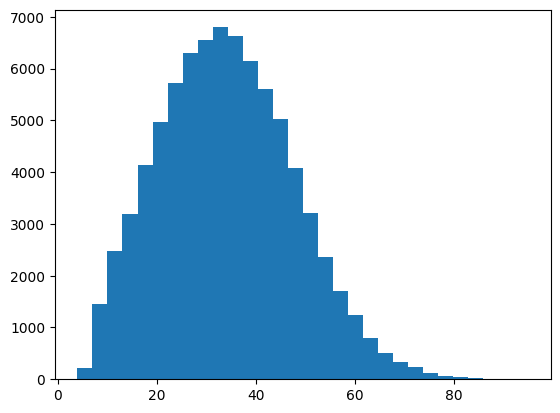

In [153]:
p = plt.hist((sdata["anucleus"].X>0).sum(axis=1), bins=30)

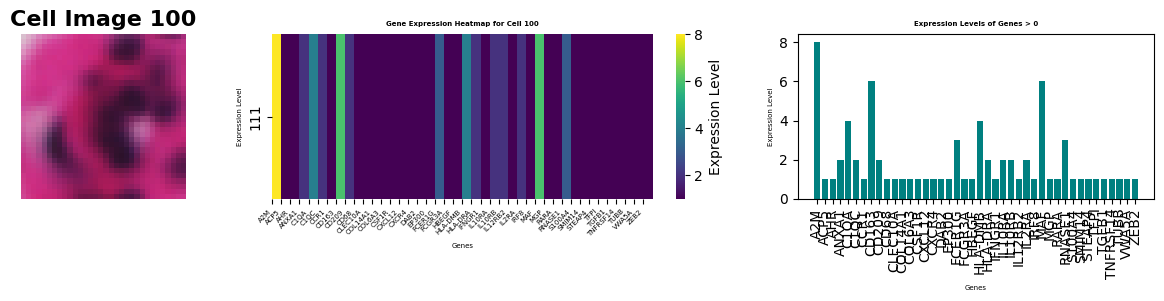

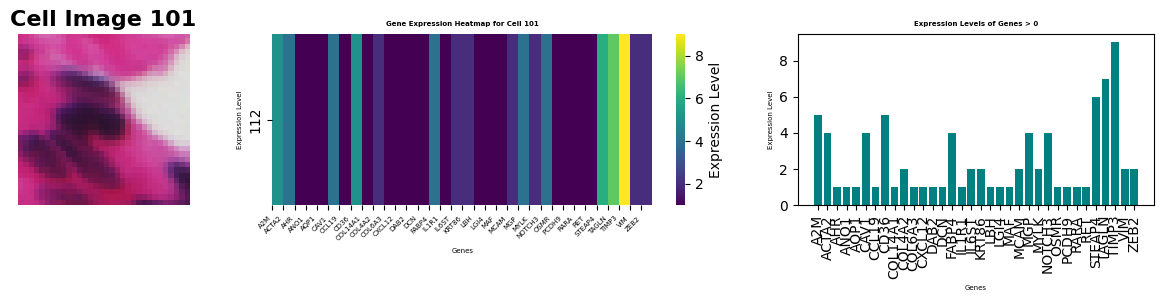

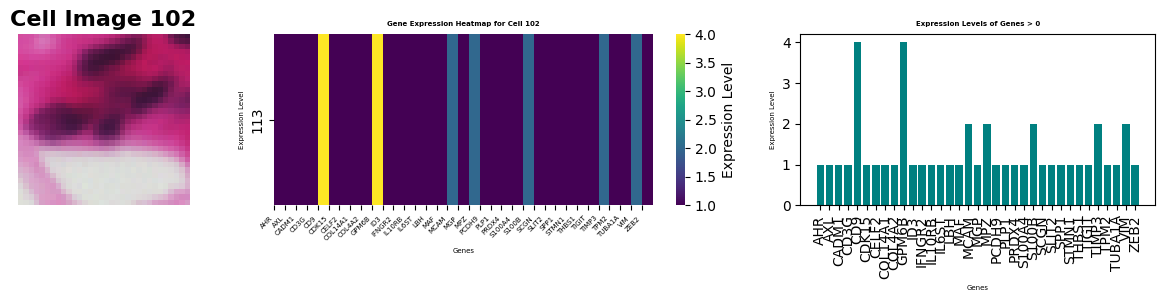

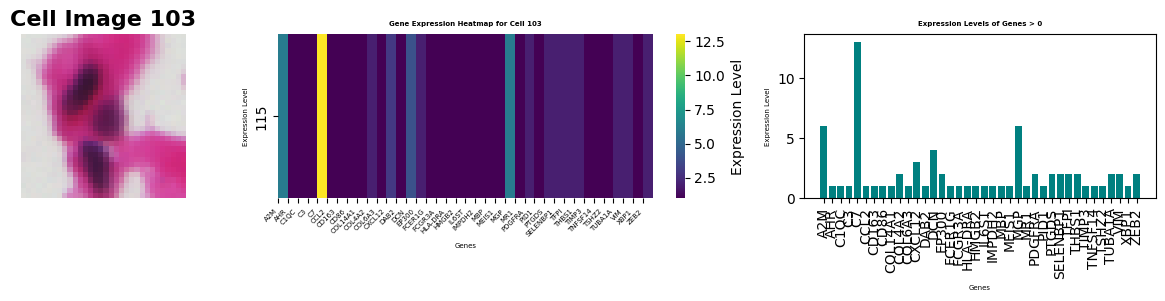

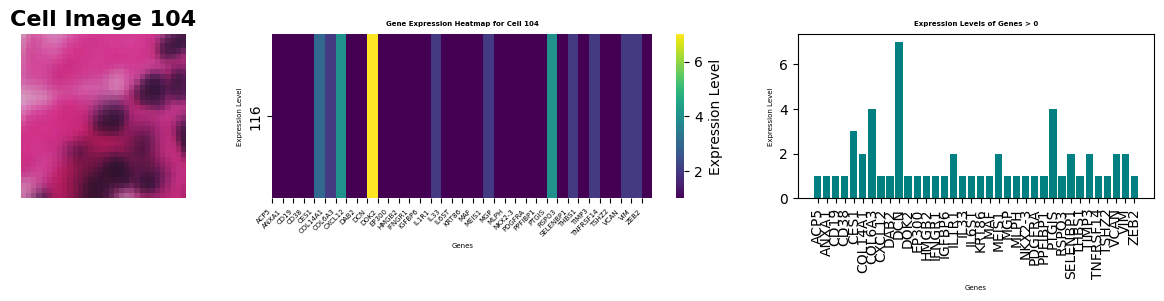

In [157]:
# Loop over the first four cells

# for cell_id in adata.obs.loc[adata.obs["leiden"]=='1']["cell_id"].to_numpy()[:10]-1:
for cell_id in range(100,105):
    # Create a figure with three subplots (image, heatmap, and bar chart)
    fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 2, 1.5]}, figsize=(12, 3))

    # First plot: Image of the cell on the left
    ax[0].imshow(crop_list[cell_id].transpose((1, 2, 0)))
    ax[0].set_title(f'Cell Image {cell_id}', fontsize=16, fontweight='bold')
    ax[0].axis('off')  # Hide axes f or image clarity

    # Filter the gene expression data to include only genes with expression > 0
    gene_expression_data = y.iloc[cell_id]
    filtered_data = gene_expression_data[gene_expression_data > 0]
    heatmap_data = pd.DataFrame(filtered_data).transpose()

    # Second plot: Gene Expression Heatmap with filtered genes
    sns.heatmap(
        heatmap_data,
        annot=False,
        cmap='viridis',  # Color map for expression levels
        fmt=".2f",
        ax=ax[1],
        cbar_kws={'label': 'Expression Level'}  # Color bar with label
    )

    # Titles and labels with enhanced readability for heatmap
    ax[1].set_title(f'Gene Expression Heatmap for Cell {cell_id}', fontsize=5, fontweight='bold')
    ax[1].set_xlabel('Genes', fontsize=5)
    ax[1].set_ylabel('Expression Level', fontsize=5)
    ax[1].set_xticks(range(len(filtered_data.index)))
    ax[1].set_xticklabels(filtered_data.index, rotation=45, ha='right', fontsize=5)

    # Third plot: Bar Chart for gene expression levels
    ax[2].bar(filtered_data.index, filtered_data.values, color='teal')
    ax[2].set_title("Expression Levels of Genes > 0", fontsize=5, fontweight='bold')
    ax[2].set_xlabel("Genes", fontsize=5)
    ax[2].set_ylabel("Expression Level", fontsize=5)
    ax[2].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

In [123]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=5, resolution=2)

In [133]:
adata.obs.loc[adata.obs["leiden"]=='0']["cell_id"].to_numpy()[:10]-1

array([ 0,  4, 10, 15, 17, 28, 44, 50, 55, 87])

In [154]:
!crunch setup --help

Usage: crunch setup [OPTIONS] COMPETITION_NAME PROJECT_NAME [DIRECTORY]

  Setup a workspace directory with the latest submission of you code.

Options:
  --token TEXT                   Clone token to use.  [required]
  --submission INTEGER           Submission number to clone. (latest if not
                                 specified)
  --no-data                      Do not download the data. (faster)
  --no-model                     Do not download the model of the cloned
                                 submission.
  -f, --force                    Deleting the old directory (if any).
  --model-directory TEXT         Directory where your model is stored.
                                 [default: resources]
  --no-quickstarter              Disable quickstarter selection.
  --quickstarter-name TEXT       Pre-select a quickstarter.
  --show-notebook-quickstarters  Show quickstarters notebook in selection.
  --notebook                     Setup everything for a notebook environment.
  -

In [114]:
adata.obsp["distances"]

<80037x80037 sparse matrix of type '<class 'numpy.float32'>'
	with 1280592 stored elements in Compressed Sparse Row format>

In [21]:
def log1p_normalization(arr, scaling_factor=100):
    # max_vals = arr.max(axis=1, keepdims=True)
    return np.log1p((arr/np.sum(arr, axis=1)) * scaling_factor)

def scoring(model_output: pd.DataFrame, ground_truth: pd.DataFrame):
    mse = np.sum((np.square(model_output - ground_truth)).mean(axis=1))

    return mse

In [62]:
regions_ori = regionprops(sdata['HE_original'][0, :, :].to_numpy())

In [65]:
for props_ori in regions_ori:
  print(props.area)
  break

32.0


In [71]:
props_ori.moments

array([[ 2.,  3.,  9., 27.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.]])

In [27]:
sdata['anucleus'].X[sdata['anucleus'].obs["cell_id"].isin([1,3,5]),sdata['anucleus'].var["gene_symbols"]=="A2M"]

array([0.960462 , 1.3090631, 0.8628322], dtype=float32)

In [79]:
# display expression level of a given gene in coordinates along with image & nucleus (train data only!)

# def rotate_point(x, y, k):
#     # Convert degrees to radians
#     theta = np.radians(k)

#     # Apply the rotation matrix
#     x_new = x * np.cos(theta) - y * np.sin(theta)
#     y_new = x * np.sin(theta) + y * np.cos(theta)

#     return x_new, y_new

def display_sdata(sdata, cell_id_list, gene_name, spatial_coords=None):
  if spatial_coords.all() == None:
    spatial_coords, final_cell_ids = extract_spatial_positions(sdata, cell_id_list)
  else:
    assert len(spatial_coords) == len(cell_id_list)
    final_cell_ids = cell_id_list
  # arrange for image orientation
  x_coords = spatial_coords[:,0]
  y_coords = spatial_coords[:,1]
  gene_expr = sdata['anucleus'].X[
      sdata['anucleus'].obs["cell_id"].isin(cell_id_list),
      sdata['anucleus'].var["gene_symbols"]==gene_name
      ]
  # gene_expr = []
  # for cell_id in final_cell_ids:
  #   gene_expr.append(sdata['anucleus'].X[sdata['anucleus'].obs["cell_id"]==cell_id, sdata['anucleus'].var["gene_symbols"]==gene_name][0])

  # Create a figure with three subplots (image (nucleus), image (original), spatial transcriptomics)
  x_range = max(x_coords) - min(x_coords)
  y_range = max(y_coords) - min(y_coords)
  xy_ratio = y_range / x_range

  fig, axes = plt.subplots(1, 3, figsize = (3*3, 3*xy_ratio)) #gridspec_kw={'width_ratios': [1, 2, 1.5]}, figsize=(12, 3))
  axes = axes.flatten()  # Flatten the axes to easily index them
  axes[0].imshow(sdata["HE_nuc_original"][0,:,:].to_numpy())
  axes[0].invert_yaxis()
  # Transpose the matrix to n*m*3 for visualization
  rgb_image_t = np.transpose(sdata["HE_original"].to_numpy(), (1, 2, 0))
  axes[1].imshow(rgb_image_t)
  axes[1].invert_yaxis()
  p = axes[2].scatter(x_coords, y_coords, c=gene_expr, cmap='RdYlBu_r', s=.5, alpha=0.7, edgecolor=None)
  axes[2].set_title(gene_name)
  # sdata.pl.render_images("HE_nuc_original").pl.show(ax=axes[0], title="H&E registered image", coordinate_systems="global")
  # sdata.pl.render_images("HE_original").pl.show(ax=axes[1], title="H&E original image", coordinate_systems="global")
  # Add colorbar
  # colorbar = plt.colorbar(p)
  # colorbar.set_label(gene_name)

  # Adjust layout for clarity
  plt.tight_layout()
  plt.show()

In [23]:
sdata['anucleus']

AnnData object with n_obs × n_vars = 80037 × 460
    obs: 'cell_id'
    var: 'gene_symbols'
    obsm: 'spatial'
    layers: 'counts'

### Access matching cell_ids, nucleus coordinates and position HE images
1. get cell ids from `sdata["cell_id-group"]`
2. get corresponding nucleus (centroids) coordinates & positions of each cell id from `sdata['HE_nuc_original']`
3. get HE pixels from  `sdata['HE_original']`

Extracting spatial positions ...


100%|██████████| 93686/93686 [00:49<00:00, 1909.30it/s]


Number of cell ids matched: 80037
Number of cell ids in spatial transcriptomics: 80037
Number of cell ids in HE image: 93686
Cell image size: mean 46.37997426190387; std 16.185505595619226


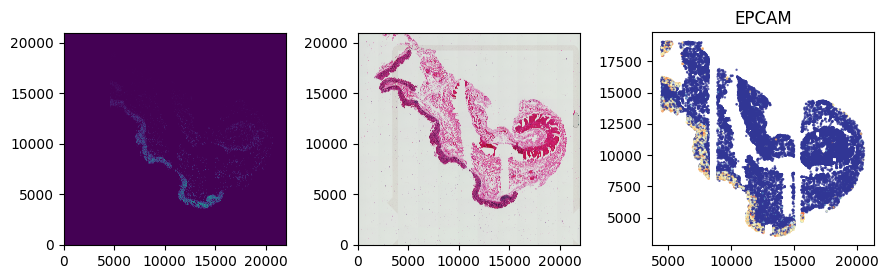

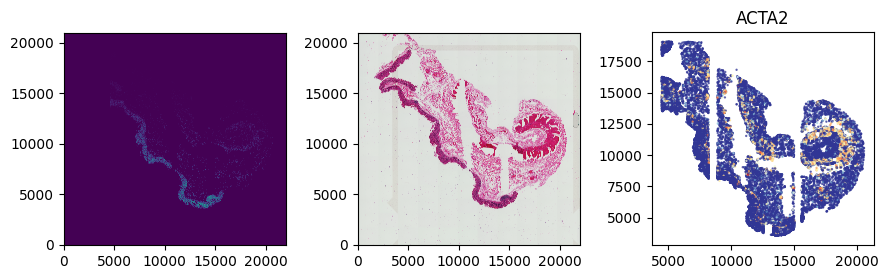

In [81]:
cell_id_list_train = sdata["cell_id-group"].obs.loc[sdata["cell_id-group"].obs["group"]=='train', "cell_id"].tolist()
spatial_coords, final_cell_ids = extract_spatial_positions(sdata, cell_id_list_train)
for gene_name in ["EPCAM", "ACTA2"]:
  display_sdata(sdata, final_cell_ids, gene_name, spatial_coords)

In [95]:
sdata["anucleus"]

AnnData object with n_obs × n_vars = 80037 × 460
    obs: 'cell_id'
    var: 'gene_symbols'
    obsm: 'spatial'
    layers: 'counts'

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 460 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


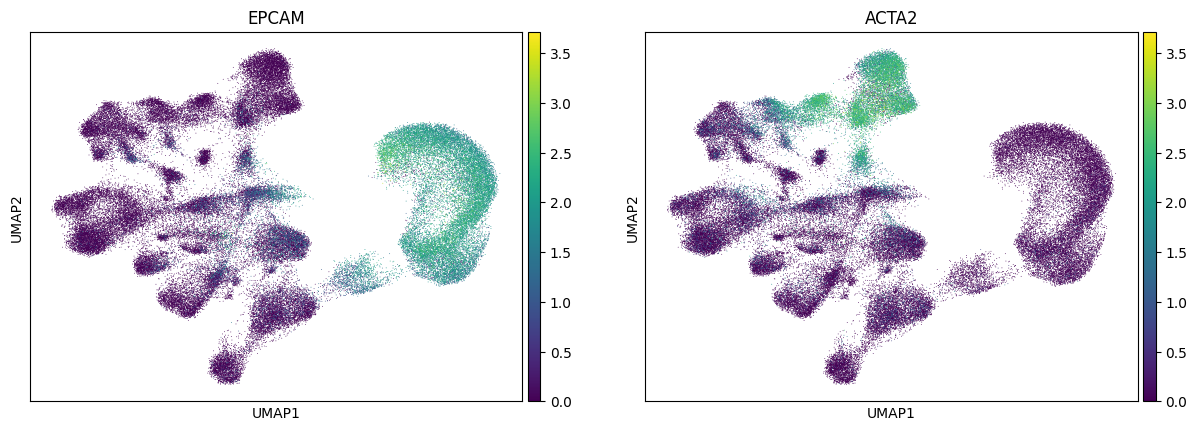

In [98]:
# simple visualisation of cells based on gene expression profile
adata = ad.AnnData(sdata["anucleus"])
sc.pp.neighbors(adata)
sc.pp.pca(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["EPCAM", "ACTA2"])

From eyeballing, The two query genes have both clear spatial and expression-level patterns

In [18]:
##########
# Preprocessing spatial transcriptomics data
##########

def extract_spatial_positions(sdata, cell_id_list):
    """
    Extracts spatial positions (centroids) of regions from the nucleus image where cell IDs match the provided cell list.

    Need to use 'HE_nuc_original' to extract spatial coordinate of cells
    HE_nuc_original: The nucleus segmentation mask of H&E image, in H&E native coordinate system. The cell_id in this segmentation mask matches with the nuclei by gene matrix stored in anucleus.
    HE_nuc_original is like a binary segmentation mask 0 - 1 but replace 1 with cell_ids.
    You can directly find the location of a cell, with cell_id, through HE_nuc_original==cell_id

    Parameters:
    -----------
    sdata: SpatialData
        A spatial data object containing the nucleus segmentation mask ('HE_nuc_original').
    cell_id_list: array-like
        A list or array of cell IDs to filter the regions.

    Returns:
    --------
    np.ndarray
        A NumPy array of spatial coordinates (x_center, y_center) for matched regions.
    """

    print("Extracting spatial positions ...")
    # Get region properties from the nucleus image: for each cell_id get its location on HE image
    regions = regionprops(sdata['HE_nuc_original'][0, :, :].to_numpy())

    dict_spatial_positions = {}
    # Loop through each region and extract centroid if the cell ID matches
    for props in tqdm(regions):
        cell_id = props.label
        centroid = props.centroid
        # Extract only coordinates from the provided cell_id list
        if cell_id in cell_id_list:
            y_center, x_center = int(centroid[0]), int(centroid[1])
            dict_spatial_positions[cell_id] = [x_center, y_center]
    print(f"Number of cell ids matched: {len(dict_spatial_positions)}")
    print(f"Number of cell ids in spatial transcriptomics: {len(cell_id_list)}")
    print(f"Number of cell ids in HE image: {len(regions)}")
    # To maintain cell IDs order (1->max)
    spatial_positions = []
    for cell_id in cell_id_list:
        try:
            spatial_positions.append(dict_spatial_positions[cell_id])
        except KeyError:
            print(f"Warning: Cell ID {cell_id} not found in the segmentation mask.")
            spatial_positions.append([1000, 1000])

    return np.array(spatial_positions)


def process_and_visualize_image(sdata, patch_save_dir, name_data, coords_center, target_patch_size, barcodes,
                                show_extracted_images=False, vis_width=1000):
    """
    Load and process the spatial image data, creates patches, saves them in an HDF5 file,
    and visualizes the extracted images and spatial coordinates.

    Parameters:
    -----------
    sdata: SpatialData
        A spatial data object containing the image to process ('HE_original') and associated metadata.
    patch_save_dir: str
        Directory where the resulting HDF5 file and visualizations will be saved.
    name_data: str
        Name used for saving the dataset.
    coords_center: array-like
        Coordinates of the regions to be patched (centroids of cell regions).
    target_patch_size: int
        Size of the patches to extract from the image.
    barcodes: array-like
        Barcodes associated with patches.
    show_extracted_images: bool, optional (default=False)
        If True, will show extracted images during the visualization phase.
    vis_width: int, optional (default=1000)
        Width of the visualization images.
    """

    # Load the image and transpose it to the correct format
    print("Loading imgs ...")
    intensity_image = np.transpose(sdata['HE_original'].to_numpy(), (1, 2, 0))

    print("Patching: create image dataset (X) ...")
    # Path for the .h5 image dataset
    h5_path = os.path.join(patch_save_dir, name_data + '.h5')

    # Create the patcher object to extract patches (localized square sub-region of an image) from an image at specified coordinates.
    patcher = Patcher(
        image=intensity_image,
        coords=coords_center,
        patch_size_target=target_patch_size
    )

    # Build and Save patches to an HDF5 file
    patcher.to_h5(h5_path, extra_assets={'barcode': barcodes})

    # Visualization
    print("Visualization")
    if show_extracted_images:
        print("Extracted Images (high time and memory consumption...)")
        patcher.save_visualization(os.path.join(patch_save_dir, name_data + '_viz.png'), vis_width=vis_width)

    print("Spatial coordinates")
    patcher.view_coord_points(vis_width=vis_width)

    # Display some example images from the created dataset
    print("Examples from the created .h5 dataset")
    assets, _ = read_assets_from_h5(h5_path)

    n_images = 3
    fig, axes = plt.subplots(1, n_images, figsize=(15, 5))
    for i in range(n_images):
        axes[i].imshow(assets["img"][i])
    for ax in axes:
        ax.axis('off')
    plt.show()

    # Delete variables that are no longer used
    del intensity_image, patcher, assets
    gc.collect()


def preprocess_spatial_transcriptomics_data_train(list_ST_name_data, data_directory_path, dir_processed_dataset, size_subset=None, target_patch_size=32, vis_width=1000, show_extracted_images=False):
    """
    Train step: Preprocesses spatial transcriptomics data by performing the following steps for each ST:
    1. Samples the dataset and extract spatial coordinates of cells.
    2. Extract gene expression data (Y) and save it as `.h5ad` files into directory 'adata'.
    4. Generates and saves patches of images centered on spatial coordinates to HDF5 files (X) into directory 'patches'.
    5. Saves the list of genes to a JSON file into direcotry 'splits'.

    Parameters:
    -----------
    list_ST_name_data: list
        List of spatial transcriptomics data names.
    data_directory_path: str
        Path to the directory containing the input data in `.zarr` format.
    dir_processed_dataset: str
        Path to the directory where processed datasets and outputs will be saved.
    size_subset: int, optional
        ST data sample size. If None, no sampling.
    target_patch_size: int, optional
        Target size of image patches to extract.
    vis_width: int, optional
        Width of the visualization output for spatial and image patches.
    show_extracted_images: bool
    """

    # Creates directories for saving patches (X) ('patches'), processed AnnData objects (Y) ('adata'), and train/test dataset splits ('splits').
    patch_save_dir = os.path.join(dir_processed_dataset, "patches")
    adata_save_dir = os.path.join(dir_processed_dataset, "adata")
    splits_save_dir = os.path.join(dir_processed_dataset, "splits")
    os.makedirs(patch_save_dir, exist_ok=True)
    os.makedirs(adata_save_dir, exist_ok=True)
    os.makedirs(splits_save_dir, exist_ok=True)

    print("\n -- PREPROCESS SPATIAL TRANSCRIPTOMICS DATASET --------------------------------------------\n")

    # Loop through each dataset name
    for count, name_data in enumerate(list_ST_name_data):
        print(f"\nDATA ({count+1}/{len(list_ST_name_data)}): {name_data}\n")

        # Load the spatial transcriptomics data from the .zarr format
        sdata = sd.read_zarr(os.path.join(data_directory_path, f"{name_data}.zarr"))

        # Extract the list of gene names
        gene_name_list = sdata['anucleus'].var['gene_symbols'].values

        # Sample the dataset if a subset size is specified
        if size_subset is not None:
            print("Sampling the dataset ...")
            rows_to_keep = list(sdata['anucleus'].obs.sample(n=min(size_subset, len(sdata['anucleus'].obs)), random_state=42).index)
        else:
            size_subset = len(sdata['anucleus'].obs)
            rows_to_keep = list(sdata['anucleus'].obs.sample(n=size_subset, random_state=42).index)

        # Extract spatial positions for 'train' cells
        cell_id_train = sdata['anucleus'].obs["cell_id"].values
        new_spatial_coord = extract_spatial_positions(sdata, cell_id_train)
        # Store new spatial coordinates into sdata
        sdata['anucleus'].obsm['spatial'] = new_spatial_coord

        # Create the gene expression dataset (Y)
        print("Create gene expression dataset (Y) ...")
        y_subtracted = sdata['anucleus'][rows_to_keep].copy()
        # Trick to set all index to same length to avoid problems when saving to h5
        y_subtracted.obs.index = ['x' + str(i).zfill(6) for i in y_subtracted.obs.index]

        # Save the gene expression data to an H5AD file
        y_subtracted.write(os.path.join(adata_save_dir, f'{name_data}.h5ad'))

        for index in y_subtracted.obs.index:
            if len(index) != len(y_subtracted.obs.index[0]):
                warnings.warn("indices of y_subtracted.obs should all have the same length to avoid problems when saving to h5", UserWarning)

        # Extract spatial coordinates and barcodes (cell IDs) for the patches
        coords_center = y_subtracted.obsm['spatial']
        barcodes = np.array(y_subtracted.obs.index)

        # Generate and visualize image patches centered around spatial coordinates ({name_data}.h5 file in directory os.path.join(dir_processed_dataset, "patches"))
        process_and_visualize_image(sdata, patch_save_dir, name_data, coords_center, target_patch_size, barcodes,
                                    show_extracted_images=False, vis_width=1000)

        # Delete variables that are no longer used
        del sdata, y_subtracted
        gc.collect()

    # Save the gene list to a JSON file
    gene_path = os.path.join(dir_processed_dataset, 'var_genes.json')
    print(f"Save gene list in {gene_path}")
    data = {
        "genes": list(gene_name_list)
    }
    print("Total number of genes:", len(data["genes"]))

    with open(gene_path, "w") as f:
        json.dump(data, f, indent=4)

    print("\nPreprocess dataset DONE:", " - ".join(list_ST_name_data), "\n")


def preprocess_spatial_transcriptomics_data_test(name_data, sdata, cell_id_list, dir_processed_dataset, target_patch_size=32, vis_width=1000, show_extracted_images=False):
    """
    Test step: Preprocesses spatial transcriptomics data by performing the following steps for the selected ST data:
    1. Extract spatial coordinates of the selected cells.
    2. Generates and saves patches of images centered on spatial coordinates to HDF5 files (X) into directory 'patches'.

    Parameters:
    -----------
    name_data: str
        Name used for saving the dataset.
    sdata: SpatialData
        A spatial data object containing the image to process ('HE_original') and associated metadata.
    cell_id_list : array-like
        A list or array of cell IDs to filter the regions.
    dir_processed_dataset: str
        Path to the directory where processed datasets and outputs will be saved.
    target_patch_size: int, optional
        Target size of image patches to extract.
    vis_width: int, optional
        Width of the visualization output for spatial and image patches.
    show_extracted_images: bool
    """

    # Creates directories for saving patches ('patches')
    patch_save_dir = os.path.join(dir_processed_dataset, "patches")
    os.makedirs(patch_save_dir, exist_ok=True)

    print("\n -- PREPROCESS SPATIAL TRANSCRIPTOMICS DATASET --------------------------------------------\n")

    # Extract spatial positions for selected cells
    new_spatial_coord = extract_spatial_positions(sdata, cell_id_list)

    # Spatial coordinates and barcodes (cell IDs) for the patches
    coords_center = new_spatial_coord
    barcodes = np.array(['x' + str(i).zfill(6) for i in list(cell_id_list)])  # Trick to set all index to same length to avoid problems when saving to h5

    # Generate and visualize image patches centered around spatial coordinates ({name_data}.h5 file in directory os.path.join(dir_processed_dataset, "patches"))
    process_and_visualize_image(sdata, patch_save_dir, name_data, coords_center, target_patch_size, barcodes,
                                show_extracted_images=False, vis_width=1000)

    print("\nPreprocess dataset DONE\n")